## Data Preparation

In [2]:
import json
with open('action_types.json', 'r') as f:
    action_types = json.load(f)

import pandas as pd
from preprocess_data import *
df = (
    pd.read_csv("WSL_actions.csv", index_col = 0)
    .pipe(add_coordinate_bins, n_bins_x = 10, n_bins_y = 10)
    .pipe(add_team_as_dummy)
    .pipe(get_action_type_names, action_types)
    .pipe(get_action_tokens)
    .assign(
        group_id = lambda d: d.groupby(['game_id', 'period_id']).ngroup(),
        action_token = lambda d: pd.Categorical(d.action_token)
    )
    [['group_id', 'action_token']]
)

vocab = df['action_token'].cat.categories

from numpy.random import choice, seed
seed(42)
train_groups = choice(df['group_id'].unique(), int(0.8 * df['group_id'].nunique()), replace = False)
val_groups = choice(train_groups, int(0.8 * len(train_groups)), replace = False)
train_groups[:5]

array([ 55, 363, 406, 428, 402], dtype=int64)

In [3]:
train_df = df.query("group_id.isin(@train_groups) and ~group_id.isin(@val_groups)")
val_df = df.query("group_id.isin(@val_groups)")

X_train = np.lib.stride_tricks.sliding_window_view(train_df['action_token'].map(list(vocab).index), (3,))[:-1]
y_train = np.lib.stride_tricks.sliding_window_view(train_df['action_token'].map(list(vocab).index), (3,))[1:]

X_val = np.lib.stride_tricks.sliding_window_view(val_df['action_token'].map(list(vocab).index), (3,))[:-1]
y_val = np.lib.stride_tricks.sliding_window_view(val_df['action_token'].map(list(vocab).index), (3,))[1:]

## Prepare Model

In [6]:
import torch
from models import BasicTransformer

if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

model = BasicTransformer(len(vocab), 128, 128, 2, 2, 0.1).to(device=device)
model.load_state_dict(torch.load("transformer_weights.pkl", map_location=torch.device('cpu')))
model.eval()

BasicTransformer(
  (encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
        )
        (linear1): Linear(in_features=128, out_features=2, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=2, out_features=128, bias=True)
        (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
    (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  )
  (decoder): Linear(in_features=128, out_features=2856, bias=True)
  (pos_encoder): PositionalEncoding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (input_emb): Embedding(2856, 128)
)

## Model Evaluation

In [4]:
!pip install matplotsoccer

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for matplotsoccer: filename=matplotsoccer-0.0.8-py3-none-any.whl size=5986 sha256=daed9304e0159fc774b2f43d7ac194759e81c7b5ca88615b1170f112c2e52697
  Stored in directory: c:\users\ethan\appdata\local\pip\cache\wheels\5f\96\51\a91e3de14cbbb035d664ca08bf412678bda3e5c7864f9ba66d
Successfully built matplotsoccer



[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [35]:
import matplotsoccer as pltsoc

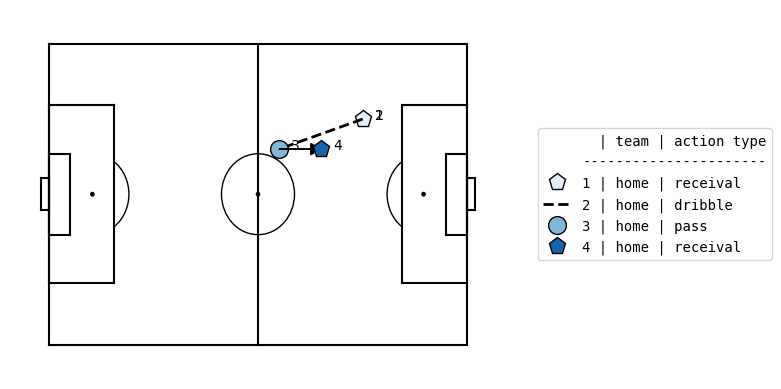

In [37]:
pred = True
pid = 200

loc = []
act = []
team = []

for i in range(X_train.shape[1]):
  splt = vocab[X_train[pid,i]].split(',')

  if splt[0] == "True":
    team.append("home")
  else:
    team.append("away")

  act.append(splt[1])

  locx = (float(splt[2]) + 0.5) * 10.5
  locy = (float(splt[3]) + 0.5) * 6.8

  loc.append([locx,locy])

if not pred:
  splt = y[pid,-1].split(',')

  if splt[0] == "True":
    team.append("home")
  else:
    team.append("away")

  act.append(splt[1])

  locx = (float(splt[2]) + 0.5) * 10.5
  locy = (float(splt[3]) + 0.5) * 6.8

  loc.append([locx,locy])

else:
  model.eval()
  input = X_train[pid:pid+1]
  output = model(torch.from_numpy(input)).argmax(dim=-1)
  play = vocab[output[0,-1].item()]

  splt = play.split(',')

  if splt[0] == "True":
    team.append("home")
  else:
    team.append("away")

  act.append(splt[1])

  locx = (float(splt[2]) + 0.5) * 10.5
  locy = (float(splt[3]) + 0.5) * 6.8

  loc.append([locx,locy])


pltsoc.actions(loc,
               team=team,
               action_type=act,
               label=[[team[i],act[i]] for i in range(len(team))],
               labeltitle=["team","action type"])
